# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.

# Team members - Group 66

* César Guillermo Vázquez Álvarez - A01197857
* Francisco Vázquez Martínez - A01797089
* Manuel Alejandro Vázquez Meza - A01796404
* Ricardo Andrés Vargas Martínez - A01797243


In [5]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import matplotlib.image as mpimg

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline
np.random.seed(11)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
CURRENT_PATH = os.getcwd()
DATA_PATH = f'{CURRENT_PATH}/asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importing Images

In [8]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [9]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''Splits the data into validation and test sets based on the given percentage.
    Inputs:
        x: numpy array of features
        y: numpy array of labels
        pct: percentage of data to use for validation
        shuffle: whether to shuffle the data before splitting
    Outputs:
        x_val: numpy array of validation features
        y_val: numpy array of validation labels
        x_test: numpy array of test features
        y_test: numpy array of test labels 
    '''
    if shuffle:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
    split_idx = int(x.shape[0] * pct)
    x_val = x[:split_idx]
    y_val = y[:split_idx]
    x_test = x[split_idx:]
    y_test = y[split_idx:]
    return x_val, y_val, x_test, y_test 

In [10]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [11]:
### The following
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalize

In [12]:
def normalize(x_mean, x_std, x_data):
    """
    Normalizes the data using the provided mean and standard deviation.
    Inputs:
        x_mean: mean of the training data
        x_std: standard deviation of the training data
        x_data: data to be normalised
    Outputs:        normalised data 
    """
    return (x_data - x_mean) / x_std

In [13]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalize(x_mean, x_std, x_train)
x_val = normalize(x_mean, x_std, x_val)
x_test = normalize(x_mean, x_std, x_test)

### Graph samples

In [14]:
def load_images_to_dict(folder_path):
    """
    Loads images from a folder into a dictionary.
    Keys: Filename without extension.
    Values: Image data (NumPy array).
    """
    image_dict = {}
    
    # Supported formats for matplotlib
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    
    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return image_dict

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(valid_extensions):
            # Get the name without the extension
            key = os.path.splitext(filename)[0]
            
            # Create full path and load image
            img_path = os.path.join(folder_path, filename)
            try:
                img_data = mpimg.imread(img_path)
                image_dict[key] = img_data
            except Exception as e:
                print(f"Could not load {filename}: {e}")
                
    return image_dict


def display_two_images(img1,img2, key1, key2):
    """
    Displays two images from the dictionary side by side.
    """

    # Create a figure with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Display first image
    axes[0].imshow(img1)
    axes[0].set_title(key1)
    axes[0].axis('off')  # Hide tick marks

    # Display second image
    axes[1].imshow(img2)
    axes[1].set_title(key2)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
images = load_images_to_dict('./asl_reference')
print(f"Loaded images for letters: {list(images.keys())}")
rnd_idx = np.random.randint(len(y_test))
print(rnd_idx)
predicted_letter = alphabet[y_test[rnd_idx]]
print(f"Predicted letter: {predicted_letter}")

display_two_images(x_test[rnd_idx].reshape(28, 28), images[predicted_letter], f"label: {predicted_letter.upper()}", f"Reference: {predicted_letter.upper()}")

Error: The folder './asl_reference' does not exist.
Loaded images for letters: []
3193
Predicted letter: u


KeyError: 'u'

### Ecuations for our model


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

#### Mini batches

Mini-batches are small subsets of the total training dataset used to update a model's weights during a single iteration. Instead of calculating the gradient for every single data point at once (Batch Gradient Descent) or for just one sample at a time (Stochastic Gradient Descent), mini-batching strikes a balance that offers the best of both worlds. Its importance lies in computational efficiency—allowing the use of highly optimized matrix operations on GPUs—and regularization, as the inherent noise in small batches helps the model avoid local minima and generalize better. When implementing them, the most critical factor is the batch size: too small, and the training becomes slow and unstable; too large, and you risk exhausting your GPU memory or converging to a "sharp" minimum that performs poorly on new data. Additionally, it is vital to shuffle your data every epoch to ensure each batch is a representative, random sample of the overall distribution.

We choose to implement a mini-batch loader class vs the simple funtion to create minibatches as its offer some advantages like:
- State encapsulation: the class tracks the current position and handles logic like reshuffling at the start of each epoch
- Extensibility: You can easily add methods for data augmentation, normalization, or even multi-threading later on.
- Lazy loading: loading just one minibatch into memomy instead of the whole dataset* 

*In this case due to the format of how the data is stored (a single csv file vs individual images) the lazy loading benefits do not apply 

In [ ]:
class MiniBatchLoader:
    """An iterable mini-batch generator for large-scale data processing.

    This class partitions features and labels into smaller chunks (batches). 
    Unlike static list-based batching, this class uses lazy loading and 
    index-shuffling to maintain a low memory footprint while ensuring the 
    stochastic nature of the training process.

    Attributes:
        x_data (np.ndarray): The input feature matrix of shape (N, ...).
        y_data (np.ndarray): The target label array of shape (N, ...).
        batch_size (int): The number of samples to return per iteration.
        shuffle (bool): If True, re-randomizes sample order every time 
            the iterator is restarted (at the start of an epoch).
        n_samples (int): Total count of samples in the provided dataset.
        indices (np.ndarray): Integer array representing the order of samples.
        current_idx (int): Internal pointer tracking the progress through 
            the dataset.

    Args:
        x_data (np.ndarray): Input features.
        y_data (np.ndarray): Target labels.
        batch_size (int, optional): Size of each mini-batch. Defaults to 32.
        shuffle (bool, optional): Whether to shuffle data per epoch. Defaults to True.
    """

    def __init__(self, x_data, y_data, batch_size=32, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_samples = x_data.shape[0]
        self.indices = np.arange(self.n_samples)
        self.current_idx = 0

    def __iter__(self):
        """Prepares the loader for a new pass over the data.

        If shuffling is enabled, the index array is randomized in-place.
        The internal pointer is reset to zero.

        Returns:
            MiniBatchLoader: The instance itself as an iterator.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.current_idx = 0
        return self

    def __next__(self):
        """Fetches the next available batch of features and labels.

        Returns:
            tuple: A pair containing (x_batch, y_batch) as numpy arrays.

        Raises:
            StopIteration: If all samples have been processed for the current epoch.
        """
        if self.current_idx >= self.n_samples:
            raise StopIteration
        
        start = self.current_idx
        end = min(start + self.batch_size, self.n_samples)
        
        batch_indices = self.indices[start:end]
        x_batch = self.x_data[batch_indices]
        y_batch = self.y_data[batch_indices]
        
        self.current_idx = end
        return x_batch, y_batch

    def __len__(self):
        """Calculates the total number of batches available.

        Returns:
            int: The number of batches in one full pass of the data.
        """
        return int(np.ceil(self.n_samples / self.batch_size))

## Our Parameter, Linear, ReLU & Sequential Classes

### Parameter class

The parameter class acts as a dedicated container for tensors that require gradient tracking during backpropagation. It encapsulates the weight or bias values and their corresponding gradients in a single object.

Creatring a class to hold the value and the gradient for the weights or biases has some advantages:
- Explicit contract: you now what a parameter object cointains by reading the class.
- Type safety: it prevents errors from accidentally triging to access a gradiend before is asigned
- Extensibility: additional fucntuonality can be added like a flag to "Freeze" layers, add properties like first movement and second movement used un optimized like adam 
I


In [ ]:
import numpy as np

class Parameter:
    """
    This class encapsulates a weight or bias tensor and its corresponding 
    gradient. It mimics a standard NumPy array by proxying attribute 
    access (like .shape, .size, .T) to the underlying data.

    Attributes:
        value (np.ndarray): The actual numerical data of the parameter.
        grad (np.ndarray): The gradient of the loss with respect to this 
            parameter. Initialized to zeros with the same shape as `value`.
    """

    def __init__(self, value):
        self.value = np.array(value)
        self.grad = np.zeros_like(self.value)

    def __getattr__(self, name):
        """
        Redirects attribute access to the underlying NumPy array.

        This allows calling `param.shape` or `param.ndim` directly on 
        the Parameter object instead of `param.value.shape`.
        """
        return getattr(self.value, name)

    def __repr__(self):
        """
        Returns a string representation including shape and gradient magnitude.
        
        The gradient norm is a useful debugging metric to check for 
        vanishing or exploding gradients during training.
        """
        grad_norm = np.linalg.norm(self.grad)
        return f"Parameter(shape={self.shape}, grad_norm={grad_norm:.4e})"

### Parameter class demo

In [ ]:
param  = Parameter(np.array([[1.0, 2.0], [3.0, 4.0]]))

print(f"Value of the param:\n {param.value}")
print(f"\nGradient of the param:\n {param.grad}")   
print(f"\nString representation of the param:\n {param}")
print(f"\nAccessing the shape of the np.array as it it was an attribute of the param:\n {param.shape}")

Value of the param:
 [[1. 2.]
 [3. 4.]]

Gradient of the param:
 [[0. 0.]
 [0. 0.]]

String representation of the param:
 Parameter(shape=(2, 2), grad_norm=0.0000e+00)

Accessing the shape of the np.array as it it was an attribute of the param:
 (2, 2)


### Linear Class

A linear layer acts as the fundamental building block of a neural network, performing an affine transformation on incoming data. It takes an input vector and multiplies it by a weight matrix (W) to project the data into a new feature space, followed by the addition of a bias vector (b). This process allows the network to learn linear relationships between features, effectively scaling, rotating, and shifting the data to identify patterns. While the operation itself is mathematically simple, these layers with non-linear activations allows the network to approximate incredibly complex, high-dimensional functions.

We just made an improvemnt on the class shared, by adding a more flexible way to select the initialization method by passing a funtion

Forward pass 

 $$y = W^T X + b$$


| Term | Mathematical Name | Practical Role |
|------|-------------------|----------------|
| X    | Input Vector      | The features or data being analyzed. |
| W    | Weight Matrix     | The "learned" importance of each feature. |
| b    | Bias Vector       | The "flexibility" to shift the model's baseline. |
| y    | Output (Logit)    | The raw prediction or signal for the next layer. |

Backward pass 

$$
\begin{aligned}
\frac{\partial L}{\partial W} &= X \frac{\partial L}{\partial y} \\
\frac{\partial L}{\partial b} &= \frac{\partial L}{\partial y} \\
\frac{\partial L}{\partial X} &= W \frac{\partial L}{\partial y}
\end{aligned}
$$



| Term            | Mathematical Name              | Practical Role |
|-----------------|--------------------------------|----------------|
| L               | Loss funtion                   | A function measuring how wrong model predictions are compared to targets. |
| ∂L/∂y           | Output Gradient                | How much the loss changes with respect to the output. |
| ∂L/∂W           | Weight Gradient                | How each weight should change to reduce the loss. |
| ∂L/∂b           | Bias Gradient                  | How the bias should shift to reduce the loss. |
| ∂L/∂X           | Input Gradient                 | How the input influences the loss (used to propagate error backward). |



In [ ]:
import numpy as np

class Linear:
    def __init__(self, in_features, out_features, init_fn=None):
        """
        Args:
            in_features: Number of input dimensions.
            out_features: Number of output dimensions.
            init_fn: A callable that takes (out_dim, in_dim) and returns a numpy array.
                     If None, defaults to  Kaiming He Initialization.
        """
        if init_fn is None:
            limit = np.sqrt(2 / in_features)
            weights_val = np.random.randn(out_features, in_features) * limit
        else:
            weights_val = init_fn(out_features, in_features)
            
        self.weights = Parameter(weights_val)
        self.bias = Parameter(np.zeros((1, out_features)))
        self.input_cache = None

    def forward(self, x):    
        self.input_cache = x
        return x @ self.weights.T + self.bias.value

    def backward(self, grad_output):
        self.weights.grad = grad_output.T @ self.input_cache
        self.bias.grad = np.sum(grad_output, axis=0, keepdims=True)
        return grad_output @ self.weights.value

### Linear class demo

We use 2 different ways to initialize the layers, we can notice the sparse initialization leaves a persentange of layers as 0

In [ ]:
def sparse_init(out_dim, in_dim, sparsity=0.5):
    """sparsity: fraction of weights to be non-zero"""
    weights = np.zeros((out_dim, in_dim))
    n_nonzero = int(sparsity * in_dim)
    
    for i in range(out_dim):
        indices = np.random.choice(in_dim, n_nonzero, replace=False)
        weights[i, indices] = np.random.randn(n_nonzero)
    return weights

In [ ]:
x = np.random.randn(1, 3)

layer = Linear(3, 2)
layer_sparse = Linear(3, 2, sparse_init)

# Weights and biases
print(f"Weights Kaiming He:\n {layer.weights.value}")
print(f"Weights sparse:\n {layer_sparse.weights.value}")
print(f"Bias Kaiming He:\n {layer.bias.value}")    
print(f"Bias sparse:\n {layer_sparse.bias.value}")    

# Forward
out = layer.forward(x)
print(f"Forward Output Kaiming He: {out}")

out = layer_sparse.forward(x)
print(f"Forward Output sparse: {out}")

# Backward (dummy gradient of 1s)
grad_in = layer.backward(np.ones_like(out))
print(f"Weight Gradient Shape Kaiming He: {layer.weights.grad.shape}")

grad_in = layer_sparse.backward(np.ones_like(out))
print(f"Weight Gradient Shape sparse: {layer_sparse.weights.grad.shape}")

Weights Kaiming He:
 [[-0.630034   -0.64123431  0.02731634]
 [-1.33302818 -0.69728019 -0.05039789]]
Weights sparse:
 [[ 0.         -0.32554662  0.        ]
 [ 0.          0.         -0.96423327]]
Bias Kaiming He:
 [[0. 0.]]
Bias sparse:
 [[0. 0.]]
Forward Output Kaiming He: [[0.37693043 0.36957116]]
Forward Output sparse: [[ 0.1738824  -0.67476562]]
Weight Gradient Shape Kaiming He: (2, 3)
Weight Gradient Shape sparse: (2, 3)


### Clase ReLU

It introduces non-linearity, which is what allows the network to learn complex patterns instead of just acting like one giant linear equation.
Mathematically, ReLU is defined as:

$$ReLU(x)=max(0,x)$$


In [ ]:
import numpy as np

class ReLU:
    def __init__(self):
        # Cache to store which elements were > 0 during forward pass
        self.mask = None

    def forward(self, x):
        """
        Forward pass: Elements < 0 become 0.
        """
        self.mask = (x > 0)
        return np.where(self.mask, x, 0)

    def backward(self, grad_output):
        """
        Backward pass: Gradients are passed back only where x was > 0.
        """
        # The gradient of ReLU is 1 if x > 0, and 0 otherwise.
        # We multiply the incoming gradient by this local gradient.
        grad_input = grad_output * self.mask
        return grad_input

### ReLU demo
For the pass forward we notice the negative values are converted to 0 and the positive values pass unchanged

For the pass backward we notice the gradients are pass backwards only when the input was greater than 0 

In [ ]:
layer_relu = ReLU()
x = np.array([[-1,0,1], [.4,2,-1]])

# Forward
out = layer_relu.forward(x)
print(f"Forward Output: {out}")

# Backward (dummy gradient of 1s)
grad_in = layer_relu.backward(np.ones_like(out))
print(f"Gradient Input Shape: {grad_in.shape}")
print(f"Gradient Input:\n {grad_in}")

Forward Output: [[0.  0.  1. ]
 [0.4 2.  0. ]]
Gradient Input Shape: (2, 3)
Gradient Input:
 [[0. 0. 1.]
 [1. 1. 0.]]


### Sequential class

A Sequential layer acts as the architectural skeleton of a neural network, governing the flow of information through the model's various components. Rather than managing each layer’s operations manually, the Sequential container treats a series of distinct layers as a single, unified pipeline. It ensures that the output of one transformation—whether it be a linear projection or a non-linear activation—is fed seamlessly as the input to the next. By encapsulating this "forward pass" logic, the Sequential model simplifies the building of deep architectures, allowing complex hierarchies of features to emerge as data travels through the stack.

We removed the responsability of handling the update of the parameters so we can use a external class called optimized this allow to use differnt optimizers and limit the resposability of the sequential class to just pass the values forward and backwards to the secuential or activation layers.


In [ ]:
class Sequential:
    def __init__(self, *layers):
        """
        Accepts a variable number of layer instances.
        Example: model = Sequential(Linear(2, 4), ReLU(), Linear(4, 1))
        """
        self.layers = layers

    def forward(self, x):
        """
        Flows data forward through every layer.
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        """
        Flows gradients backward through every layer in reverse order.
        """
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output

    def get_parameters(self):
        """
        Utility to collect all Parameter objects (weights/biases) 
        from all layers for the optimizer.
        """
        params = []
        for layer in self.layers:
            # Check if the layer has weights (like Linear)
            if hasattr(layer, 'weights'):
                params.append(layer.weights)
            if hasattr(layer, 'bias'):
                params.append(layer.bias)
        return params

### Sequential class demo

In [ ]:
model = Sequential(
    Linear(4, 3),
    ReLU(),
    Linear(3, 2)
)
x=np.random.randn(1, 4)
print("forward:", model.forward(x))
print("backward:", model.backward(np.ones((1, 2))))
print("parameters:", model.get_parameters()[:2])

forward: [[0. 0.]]
backward: [[0. 0. 0. 0.]]
parameters: [Parameter(shape=(3, 4), grad_norm=0.0000e+00), Parameter(shape=(1, 3), grad_norm=0.0000e+00)]


### Cost Function

A Cost Function—often referred to as a loss or objective function—serves as the mathematical compass of a neural network, quantifying the discrepancy between the model's predictions and the actual ground truth. By condensing the performance of the entire network into a single scalar value, it provides a concrete measure of "error" that the optimization algorithm seeks to minimize.

We split the clas in 2 so it allows us to have a class to manage the funtions of the different loss error funtions and another one the loginc to apply them in a neural network

In [ ]:
class CostFunctions:
    @staticmethod
    def mse(y_pred, y_true):
        """Mean Squared Error"""
        loss = np.mean((y_pred - y_true)**2)
        grad = 2 * (y_pred - y_true) / y_pred.shape[0]
        return loss, grad

    @staticmethod
    def mae(y_pred, y_true):
        """Mean Absolute Error"""
        loss = np.mean(np.abs(y_pred - y_true))
        grad = np.sign(y_pred - y_true) / y_pred.shape[0]
        return loss, grad
    
    @staticmethod
    def softmax_cross_entropy(logits, y_true):
        """
        logits: Raw output from the last Linear layer (unnormalized)
        y_true: Ground truth labels (one-hot encoded)
        """
        # 1. Compute Softmax (with numerical stability trick)
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exps / np.sum(exps, axis=1, keepdims=True)
        
        # 2. Compute Cross-Entropy Loss
        batch_size = logits.shape[0]
        # Clipping to avoid log(0)
        probs_clipped = np.clip(probs, 1e-12, 1.0)
        loss = -np.sum(y_true * np.log(probs_clipped)) / batch_size
        
        # 3. Compute Gradient: (Probs - True_Labels) / Batch_Size
        grad = (probs - y_true) / batch_size
        
        return loss, grad

class Loss:
    def __init__(self, cost_fn=CostFunctions.mse):
        """
        Args:
            cost_fn: A function that returns (loss_value, gradient)
        """
        self.cost_fn = cost_fn
        self.grad = None

    def forward(self, y_pred, y_true):
        """Calculates the loss and stores the gradient for later."""
        loss_val, self.grad = self.cost_fn(y_pred, y_true)
        return loss_val

    def backward(self):
        """Returns the gradient calculated during the forward pass."""
        return self.grad

### Loss function demo

In [ ]:
model = Sequential(
    Linear(4, 3),
    ReLU(),
    Linear(3, 2)
)
x = np.random.randn(1, 4)
y_true = np.array([[0, 1]])
y_pred = model.forward(x)

loss_mse = Loss(cost_fn=CostFunctions.mse)
loss_value = loss_mse.forward(y_pred, y_true)
print(f"Loss Value MSE:\n {loss_value}")
grad_loss = loss_mse.backward()
print(f"Gradient of Loss MSE:\n {grad_loss}")

loss_x_entropy = Loss(cost_fn=CostFunctions.softmax_cross_entropy)
loss_value = loss_x_entropy.forward(y_pred, y_true)
print(f"\nLoss Value X entropy:\n {loss_value}")
grad_loss = loss_x_entropy.backward()
print(f"Gradient of Loss X entropy:\n {grad_loss}")

Loss Value MSE:
 1.1705117872255673
Gradient of Loss MSE:
 [[ 2.92986238 -0.88317649]]

Loss Value X entropy:
 1.245793228929029
Gradient of Loss X entropy:
 [[ 0.7122874 -0.7122874]]


### Training loop

It acts as the bridge between static data and a dynamic model, repeatedly exposing the network to batches of information to refine its internal parameters. Within each "epoch," the loop meticulously coordinates three critical phases: the Forward Pass, where data propagates through the layers to generate a prediction; the Backward Pass, where the cost function’s error is signaled back through the architecture via gradients; and the Optimization Step, where the optimizer nudges the weights in a direction that reduces future error. By repeating this cycle thousands of times, the training loop transforms a randomly initialized set of weights into a specialized mathematical tool capable of high-level pattern recognition.

We also defined an optimizer to pass the reponsability to ajust the different parameters in this case we used stochastic gradient descent. It updates model parameters using only a single or small subset of training examples per iteration. This approach provides high computational efficiency and faster convergence, making it ideal for large-scale datasets, though it results in a noisy, erratic path towards the minimum. 

In [ ]:

class SGD:
    def __init__(self, parameters, learning_rate=0.01):
        """
        Args:
            parameters: A list of Parameter objects (weights/biases).
            learning_rate: How large of a step to take in the gradient direction.
        """
        self.parameters = parameters
        self.lr = learning_rate

    def step(self):
        """
        Updates the value of each parameter: 
        
        Value = Value - (Learning_Rate * Gradient)
        """
        for param in self.parameters:
            param.value -= self.lr * param.grad

    def zero_grad(self):
        """
        Resets the gradients of all parameters to zero.
        Crucial to call this before every backward pass.
        """
        for param in self.parameters:
            param.grad = np.zeros_like(param.value)


class Trainer:
    def __init__(self, model, criterion, optimizer):
        """
        Args:
            model: The Sequential model instance.
            criterion: The Loss instance (Strategy).
            optimizer: The Optimizer instance (e.g., SGD).
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss_history = []

    def fit(self, X, y, epochs=100, batch_size=32, verbose=True):
        """
        Trains the model using the MiniBatchLoader for data iteration.
        """
        # Initialize the data loader
        # Note: shuffle=True is standard for training to maintain stochasticity
        data_loader = MiniBatchLoader(X, y, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):
            epoch_losses = []
            
            # Using the MiniBatchLoader as an iterator
            for X_batch, y_batch in data_loader:
                # 1. Forward Pass
                predictions = self.model.forward(X_batch)
                loss = self.criterion.forward(predictions, y_batch)
                epoch_losses.append(loss)

                # 2. Backward Pass
                self.optimizer.zero_grad()
                grad_loss = self.criterion.backward()
                self.model.backward(grad_loss)

                # 3. Update Weights
                self.optimizer.step()

            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)

            if verbose and (epoch % (epochs // 10 or 1) == 0 or epoch == epochs - 1):
                # We use the last batch of the epoch for the accuracy display
                acc = calculate_accuracy(predictions, y_batch)
                print(f"Epoch {epoch:4d} | Loss: {avg_loss:.6f} | Batch Accuracy: {acc:.2f}%")



### Additional auxialiary functions

In [ ]:
def calculate_accuracy(y_pred, y_true):
    """
    Calculates the percentage of correct predictions.
    
    Args:
        y_pred: Model outputs of shape (batch_size, num_classes)
        y_true: Ground truth one-hot encoded labels of shape (batch_size, num_classes)
    """
    # Convert one-hot or probabilities to class indices (e.g., [0, 0, 1] -> 2)
    predicted_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y_true, axis=1)
    
    # Compare and take the mean
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy * 100  # Return as a percentage

def one_hot_encode(labels, num_classes):
    """
    Converts integer labels [3, 1] into [[0,0,0,1], [0,1,0,0]]
    """
    return np.eye(num_classes)[labels]

### Create your model and train it

In [ ]:
# Defining the layers of the model
model = Sequential(
    Linear(784, 400),
    ReLU(),
    Linear(400, 200),
    ReLU(),
    Linear(200, 24)
)

# Defining the loss function and the optimizer
criterion = Loss(cost_fn=CostFunctions.softmax_cross_entropy)
optimizer = SGD(model.get_parameters(), learning_rate=0.001)

#Using all the objects above to build the trainer 
trainer = Trainer(model, criterion, optimizer)

# Train the model
y_train_ohe = one_hot_encode(y_train, num_classes=24)
trainer.fit(x_train, y_train_ohe, epochs=100, batch_size=526)

Epoch    0 | Loss: 3.831764 | Batch Accuracy: 8.74%
Epoch   10 | Loss: 2.205338 | Batch Accuracy: 41.75%
Epoch   20 | Loss: 1.658224 | Batch Accuracy: 64.08%
Epoch   30 | Loss: 1.320509 | Batch Accuracy: 68.93%
Epoch   40 | Loss: 1.087318 | Batch Accuracy: 72.82%
Epoch   50 | Loss: 0.919014 | Batch Accuracy: 79.61%
Epoch   60 | Loss: 0.788631 | Batch Accuracy: 87.38%
Epoch   70 | Loss: 0.686333 | Batch Accuracy: 89.32%
Epoch   80 | Loss: 0.606871 | Batch Accuracy: 78.64%
Epoch   90 | Loss: 0.533843 | Batch Accuracy: 98.06%


### Test your model on Random data from your test set

In [ ]:

y_test_ohe = one_hot_encode(y_test, num_classes=24)
# Calculating the accuracy of the model 
y_pred = model.forward(x_test)
print(calculate_accuracy(y_pred, y_test_ohe))

70.5521472392638


2368
Predicted letter: a


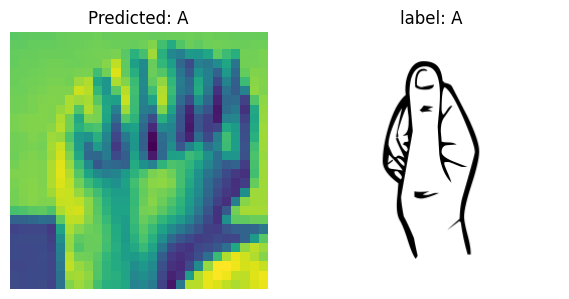

In [ ]:
#Testing with a random Image
rnd_idx = np.random.randint(len(y_test))
print(rnd_idx)

Label = alphabet[y_val[rnd_idx]]
predicted_letter = alphabet[np.argmax(model.forward(x_val[rnd_idx].reshape(1, -1)))]
print(f"Predicted letter: {predicted_letter}")

display_two_images(x_val[rnd_idx].reshape(28, 28), images[Label],  f"Predicted: {predicted_letter.upper()}", f"label: {Label.upper()}")

## Conclusions

Completing this exercise highlights that building a neural network is as much an exercise in software engineering as it is in mathematics. By trying to reproduce the code and then refactoring to introduce functional weight initialization, we moved beyond a prototiope script toward a modular framework. This transition to a more maintainable and flexible architecture is a great experience for truly grasping the internal mechanics of a network; it forces you to think about how data flows, how state is managed, and how different components—like the optimizer and the sequential container—must communicate without being tightly coupled.

Through this process, we've encountered the core challenges that developers face when implementing performant deep learning systems: balancing memory efficiency (through lazy batching), ensuring numerical stability (through proper initialization), and maintaining extensibility (through decoupled classes). Solving these hurdles manually provides an invaluable perspective on what modern libraries like PyTorch or TensorFlow are doing under the hood. Ultimately, this journey from a simple linear transformation to a robust, iterative training system reveals that the elegance of a neural network lies in its ability to solve complex problems through the repetitive application of simple, well-organized rules.
